<a href="https://colab.research.google.com/github/AnaHristian/intro_to_machine_learning/blob/master/eigenfaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Faces recognition example using eigenfaces and SVMs](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html)

In [0]:
import tarfile
from time import time
import logging
import pylab as pl
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC

In [2]:
!wget http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz 

--2019-03-26 12:55:57--  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 243346528 (232M) [application/x-gzip]
Saving to: ‘lfw-funneled.tgz’

lfw-funneled.tgz    100%[===================>] 232.07M  78.8MB/s    in 2.9s    

2019-03-26 12:56:05 (78.8 MB/s) - ‘lfw-funneled.tgz’ saved [243346528/243346528]



In [4]:
%%time
tfile = tarfile.open("lfw-funneled.tgz", "r:gz")
tfile.extractall(".")

CPU times: user 5.62 s, sys: 2.4 s, total: 8.02 s
Wall time: 8.22 s


In [0]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [11]:
# Download the data, if not already on disk and load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

2019-03-26 13:01:00,575 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2019-03-26 13:01:01,577 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2019-03-26 13:01:02,496 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2019-03-26 13:01:03,614 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


In [0]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
np.random.seed(42)

In [14]:
n_samples, h, w

(1288, 50, 37)

In [0]:
# for machine learning we use the data directly (as relative pixel
# position info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

In [0]:
# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [19]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


#### #1 Split into a training and testing set

In [0]:
# Split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### #2 Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled dataset)

* unsupervised feature extraction / dimensionality reduction

In [0]:
# the original dimensionality is over 1800
n_components = 150

In [22]:
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()
# create the PCA
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 966 faces
done in 0.447s


In [0]:
# principle components of the face data
# reshape the data so they can look like pictures
eigenfaces = pca.components_.reshape((n_components, h, w))

In [24]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
# transform the data into the principle component representation
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis
done in 0.039s


#### #3 Train a SVM classification model

In [27]:
print("Fitting the classifier to the training set")
t0 = time()
param_grids = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma':  [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
}
# create the classifier
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grids)
# fit the data
clf = clf.fit(X_train_pca, y_train)

print('done in %0.3fs' % (time() - t0))
print('Best estimator fount in grid search:')
print(clf.best_estimator_)

Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


done in 24.503s
Best estimator fount in grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


#### #4 Quantitative evaluation of the model quality on the test set

In [28]:
print("Predicting the people names on the testing set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print('done in %0.3fs' % (time() - t0))

Predicting the people names on the testing set
done in 0.057s


In [29]:
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.69      0.62        13
     Colin Powell       0.74      0.87      0.80        60
  Donald Rumsfeld       0.76      0.81      0.79        27
    George W Bush       0.93      0.87      0.90       146
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.88      0.83      0.86        36

        micro avg       0.83      0.83      0.83       322
        macro avg       0.77      0.77      0.76       322
     weighted avg       0.84      0.83      0.83       322

[[  9   0   3   1   0   0   0]
 [  2  52   1   4   0   1   0]
 [  4   0  22   1   0   0   0]
 [  1  11   2 127   3   1   1]
 [  0   2   0   1  19   1   2]
 [  0   3   0   1   2   8   1]
 [  0   2   1   2   1   0  30]]


#### #5 Qualitative evaluation of the predictions using matplotlib

In [0]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

#### #6 Plot the result of the prediction on a portion of the test set

In [0]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

In [0]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

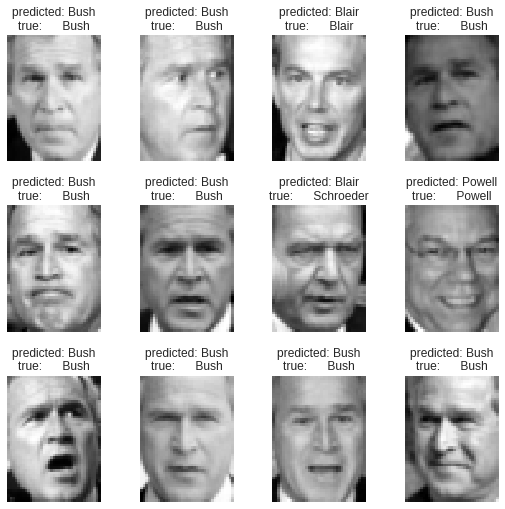

In [33]:
plot_gallery(X_test, prediction_titles, h, w)

#### #7 Plot the gallery of the most significative eigenfaces

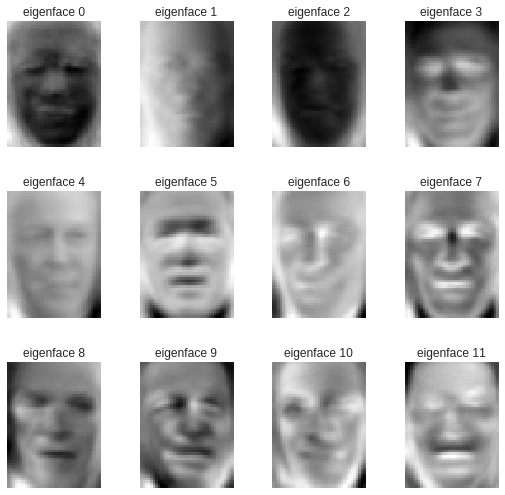

In [34]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

pl.show()

#### #8 How much of the variance is explained by the first principal component? The second?

In [40]:
pca.explained_variance_ratio_[0]

0.19346519

In [41]:
pca.explained_variance_ratio_[1]

0.1511682

#### #9 How many PCs to use? As you add more principal components as features for training your classifier, do you expect it to get better or worse performance?

Now you'll experiment with keeping different numbers of principal components. In a multiclass classification problem like this one (more than 2 labels to apply), accuracy is a less-intuitive metric than in the 2-class case. Instead, a popular metric is the F1 score.

While ideally, adding components should provide us additional signal to improve our performance, it is possible that we end up at a complexity where we overfit.

In [43]:
# the original dimensionality is over 1800
#n_components = 150

for n_components in [10, 15, 25, 50, 100, 250]:
    print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
    t0 = time()
    # create the PCA
    pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    # principle components of the face data
    # reshape the data so they can look like pictures
    eigenfaces = pca.components_.reshape((n_components, h, w))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    # transform the data into the principle component representation
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs" % (time() - t0))

    print("Fitting the classifier to the training set")
    t0 = time()
    param_grids = {
        'C': [1e3, 5e3, 1e4, 5e4, 1e5],
        'gamma':  [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
    }
    # create the classifier
    clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grids)
    # fit the data
    clf = clf.fit(X_train_pca, y_train)

    print('done in %0.3fs' % (time() - t0))
    print('Best estimator fount in grid search:')
    print(clf.best_estimator_)

    print("Predicting the people names on the testing set")
    t0 = time()
    y_pred = clf.predict(X_test_pca)
    print('done in %0.3fs' % (time() - t0))

    print(classification_report(y_test, y_pred, target_names=target_names))
    print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Extracting the top 10 eigenfaces from 966 faces
done in 0.176s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.019s
Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


done in 47.318s
Best estimator fount in grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.011s
                   precision    recall  f1-score   support

     Ariel Sharon       0.10      0.15      0.12        13
     Colin Powell       0.43      0.53      0.48        60
  Donald Rumsfeld       0.26      0.33      0.30        27
    George W Bush       0.66      0.58      0.62       146
Gerhard Schroeder       0.17      0.20      0.18        25
      Hugo Chavez       0.25      0.13      0.17        15
       Tony Blair       0.50      0.39      0.44        36

        micro avg       0.46      0.46      0.46       322
        macro avg       0.34      0.33      0.33       322
     weighted avg       0.49      0.46      0.47       322

[[

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


done in 15.994s
Best estimator fount in grid search:
SVC(C=50000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.010s
                   precision    recall  f1-score   support

     Ariel Sharon       0.26      0.46      0.33        13
     Colin Powell       0.65      0.73      0.69        60
  Donald Rumsfeld       0.46      0.63      0.53        27
    George W Bush       0.83      0.68      0.75       146
Gerhard Schroeder       0.41      0.48      0.44        25
      Hugo Chavez       0.60      0.40      0.48        15
       Tony Blair       0.50      0.50      0.50        36

        micro avg       0.63      0.63      0.63       322
        macro avg       0.53      0.55      0.53       322
     weighted avg       0.66      0.63      0.64       322

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


done in 8.679s
Best estimator fount in grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.012s
                   precision    recall  f1-score   support

     Ariel Sharon       0.60      0.69      0.64        13
     Colin Powell       0.73      0.87      0.79        60
  Donald Rumsfeld       0.50      0.56      0.53        27
    George W Bush       0.86      0.82      0.84       146
Gerhard Schroeder       0.58      0.56      0.57        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.69      0.61      0.65        36

        micro avg       0.75      0.75      0.75       322
        macro avg       0.68      0.67      0.67       322
     weighted avg       0.75      0.75      0.75       322

[[

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


done in 8.793s
Best estimator fount in grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.021s
                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.77      0.71        13
     Colin Powell       0.83      0.90      0.86        60
  Donald Rumsfeld       0.70      0.59      0.64        27
    George W Bush       0.86      0.90      0.88       146
Gerhard Schroeder       0.75      0.72      0.73        25
      Hugo Chavez       0.77      0.67      0.71        15
       Tony Blair       0.82      0.64      0.72        36

        micro avg       0.82      0.82      0.82       322
        macro avg       0.77      0.74      0.75       322
     weighted avg       0.81      0.82      0.81       322

[[

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


done in 16.748s
Best estimator fount in grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.040s
                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.69      0.69        13
     Colin Powell       0.83      0.90      0.86        60
  Donald Rumsfeld       0.81      0.63      0.71        27
    George W Bush       0.89      0.97      0.92       146
Gerhard Schroeder       0.86      0.76      0.81        25
      Hugo Chavez       0.91      0.67      0.77        15
       Tony Blair       0.87      0.75      0.81        36

        micro avg       0.86      0.86      0.86       322
        macro avg       0.84      0.77      0.80       322
     weighted avg       0.86      0.86      0.86       322



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


done in 42.896s
Best estimator fount in grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Predicting the people names on the testing set
done in 0.095s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.77      0.65        13
     Colin Powell       0.74      0.90      0.81        60
  Donald Rumsfeld       0.82      0.67      0.73        27
    George W Bush       0.92      0.89      0.90       146
Gerhard Schroeder       0.71      0.68      0.69        25
      Hugo Chavez       0.70      0.47      0.56        15
       Tony Blair       0.85      0.78      0.81        36

        micro avg       0.82      0.82      0.82       322
        macro avg       0.76      0.74      0.74       322
     weighted avg       0.83      0.82      0.82       322



#### #10 If you see a higher F1 score, does it mean the classifier is doing better, or worse?

Yes, higher means better!

#### #11 Do you see any evidence of overfitting when using a large number of PCs? Does the dimensionality reduction of PCA seem to be helping your performance here?

Yes, the F1 score starts to drop.

#### #12 Selecting a Number of Principal Components 

* train on different number of PCs and see how accuracy responds - cut off when it comes apparent that adding more PCs doesn't buy you more discrimination.

* this can be done also in feature selection as well. You don't want to do feature selection before going into PCA. PCA is going to combine information from potentially many different input features together